In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 10]

font = {'size'   : 15, }
axes = {'labelsize': 'large', 'titlesize': 'large'}

mpl.rc('font', **font)
mpl.rc('axes', **axes)

import pandas as pd
import data_utils


In [3]:
# Paths to data csvs
wd = "/home/behzad/Documents/barnes_lab/cplusplus_software/speed_test/repressilator/cpp"
data_dir = wd + "/output/two_species_big_3/Population_0"
distances_path = data_dir + "/distances.csv"
eigenvalues_path = data_dir + "/eigenvalues_do_fsolve_state.csv"
model_space_report_path = data_dir + "/model_space_report.csv"
sum_stdev = data_dir + "/sum_stdev.csv"

time_stab_path = data_dir + "/time_to_stab.csv"

In [4]:
# Load dataframes
distances_df = pd.read_csv(distances_path)
eigenvalues_df = pd.read_csv(eigenvalues_path)
time_stab_df = pd.read_csv(time_stab_path)

# Make distances numeric
distances_df = data_utils.distances_pre_processing(distances_df)

In [5]:
# Join eigenvalues and distances on the simulation index, batch number and model_ref

max_eigs = data_utils.make_max_eig(eigenvalues_df)
all_neg_eig = data_utils.all_negative_eigs(eigenvalues_df)
all_real_eig = data_utils.all_real_eigs(eigenvalues_df)
all_zero_eig = data_utils.all_zero_eigs(eigenvalues_df)
num_conj_pairs = data_utils.get_conjugate_pairs(eigenvalues_df)
imag_num_df = data_utils.set_number_imaginary(eigenvalues_df)



Index(['eig_0_real', 'eig_1_real', 'eig_2_real', 'eig_3_real', 'eig_4_real',
       'eig_5_real', 'eig_6_real', 'eig_7_real', 'eig_8_real', 'eig_9_real'],
      dtype='object')


NameError: name 'max_all_zero_eigeigs' is not defined

In [6]:
eigenvalues_df['max_eigs'] = max_eigs
eigenvalues_df['all_neg_eig'] = all_neg_eig
eigenvalues_df['all_real_eig'] = all_real_eig
eigenvalues_df['all_zero_eig'] = all_zero_eig
eigenvalues_df['num_conj_pairs'] = num_conj_pairs
eigenvalues_df['imag_num_df'] = imag_num_df


In [10]:
joint_df = pd.merge(left=eigenvalues_df, right=distances_df, how='inner', on=['sim_idx', 'batch_num', 'model_ref'])
joint_df.reset_index()

joint_df['sum_std'] = joint_df['d2'] + joint_df['d5']
# Set accepted or rejected particles
mask = (joint_df['d1'] == 0) & (joint_df['d2'] < 10) & (joint_df['d3'] > 1e4) & (joint_df['d4'] == 0) & (joint_df['d5'] < 10) & (joint_df['d6'] > 1e4)
joint_df.loc[mask, 'Accepted'] = True
joint_df.loc[~mask, 'Accepted'] = False

In [13]:
all_sims = joint_df
full_term_sims = joint_df.loc[joint_df['integ_error'].isnull()]
early_termination_sims = joint_df.loc[~joint_df['integ_error'].isnull()]
only_real_part_sims = joint_df.loc[joint_df['all_real_eig'] == True]
complex_sims = joint_df.loc[joint_df['all_real_eig'] == False]
negative_part_sims = joint_df.loc[joint_df['all_neg_eig'] == True]


only_real_and_full_term = joint_df.loc[joint_df['integ_error'].isnull() &
                                            (joint_df['all_real_eig'] == True)]

accepted_sims = joint_df.loc[joint_df['Accepted'] == True]
rejected_sims = joint_df.loc[joint_df['Accepted'] == False]

successful_fsolve = joint_df.loc[joint_df['fsolve_error'] == 1]

# Total number of simulations
print("Total sims: ", len(all_sims))
print("Num accepted: ", len(accepted_sims))
print("Num rejected: ", len(rejected_sims))
print("")
# Number of simulations that exited before reaching full term
print("Sims reaching full term: ", len(full_term_sims))

# Number of sims that completed full term
print("Sims terminated early: ", len(early_termination_sims))
print("Sims reaching full term with only real parts: ", len(only_real_and_full_term))

print("")
# Number of sims that are all real parts
print("Sims with only real parts: ", len(only_real_part_sims))

# Number sims with only real eigen values
print("Sims with all negative real parts: ", len(negative_part_sims))


print("")
print("Successful fsolve", len(successful_fsolve))
# Number of full term sims with only real eigenvalues

Total sims:  78600
Num accepted:  12210
Num rejected:  66390

Sims reaching full term:  20747
Sims terminated early:  57853
Sims reaching full term with only real parts:  2051

Sims with only real parts:  27903
Sims with all negative real parts:  45681

Successful fsolve 45369


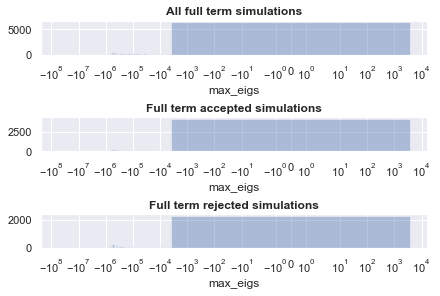

In [17]:
# Generate bins
n_bins=100
min_val = min(full_term_sims['max_eigs'])
max_val = max(full_term_sims['max_eigs'])

bin_signs = np.linspace(min_val, max_val, n_bins)

logbins = np.logspace(np.log10(abs(min_val)),np.log10(abs(max_val)), n_bins)
logbins = [np.sign(bin_signs[idx])*(abs(x)) for idx, x in enumerate(logbins)]

# # Transform bins to 'symlog scale'
# logbins = [np.sign(x)*np.log10(abs(x)) for x in bins]

# print(logbins)
f, (ax1, ax2, ax3) = plt.subplots(3, 1, constrained_layout=True)

# Make bins
sns.distplot(full_term_sims['max_eigs'], kde=False, bins=logbins, ax=ax1)
ax1.set_title('All full term simulations', fontweight="bold")


full_term_sims_acc = full_term_sims.loc[full_term_sims['Accepted'] == True]
full_term_sims_not_acc = full_term_sims.loc[full_term_sims['Accepted'] == False]

sns.distplot(full_term_sims_acc['max_eigs'], kde=False, bins=logbins, ax=ax2)
ax2.set_title('Full term accepted simulations', fontweight="bold")

sns.distplot(full_term_sims_not_acc['max_eigs'], kde=False, bins=logbins, ax=ax3)
ax3.set_title('Full term rejected simulations', fontweight="bold")

ax1.set(xscale='symlog')
ax2.set_xscale('symlog')
ax3.set_xscale('symlog')

plt.show()

65
20747
12210
12210


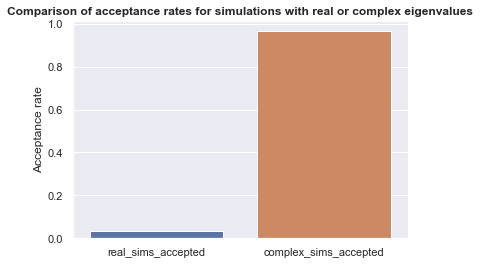

Fraction of real systems accepted:  0.034643734643734644
Fraction of complex systems accepted:  0.9653562653562654


In [32]:
accepted_sims = joint_df.loc[joint_df['Accepted'] == True]
rejected_sims = joint_df.loc[joint_df['Accepted'] == False]

print(len(full_term_sims.loc[full_term_sims['all_zero_eig']]))
print(len(full_term_sims))
print(len(accepted_sims['all_neg_eig']))
print(len(accepted_sims))
num_accepted_sims = len(accepted_sims)

stable_complex_sims = accepted_sims.loc[accepted_sims['all_real_eig'] == False]
stable_real_sims = accepted_sims.loc[accepted_sims['all_real_eig'] == True]

num_stable_real_total = len(stable_real_sims)
num_stable_real_accepted = len(stable_real_sims.loc[stable_real_sims['Accepted'] == True])

num_stable_complex_total = len(stable_complex_sims)
num_stable_complex_accepted = len(stable_complex_sims.loc[stable_complex_sims['Accepted'] == True])



frac_real_sims_accepted = num_stable_real_accepted / num_accepted_sims
frac_complex_sims_accepted = num_stable_complex_accepted / num_accepted_sims

x = ['real_sims_accepted', 'complex_sims_accepted']
y = [frac_real_sims_accepted, frac_complex_sims_accepted]
ax = sns.barplot(x=x,y=y)

ax.set(ylabel='Acceptance rate')
ax.set_title('Comparison of acceptance rates for simulations with real or complex eigenvalues', 
             fontweight="bold")

plt.savefig('real vs complex acceptance rate')
plt.show()
print("Fraction of real systems accepted: ", frac_real_sims_accepted)
print("Fraction of complex systems accepted: ", frac_complex_sims_accepted)


In [26]:
stable_real_sims

stable_complex_conj = stable_complex_sims.loc[stable_complex_sims['num_conj_pairs'] > 0]


In [27]:
col_names = stable_complex_sims.columns
eign_cols = [x for x in col_names if 'eig' in x]
eign_cols = [x for x in eign_cols if 'imag' in x]

num_conj = stable_complex_sims['num_conj_pairs'].values
num_imag = stable_complex_sims['imag_num_df'].values

all_conj = []

for idx, i in enumerate(num_conj):
    if num_conj[idx] == (num_imag[idx]/2):
        all_conj.append(True)
    
    else:
        all_conj.append(False)

stable_complex_sims['all_conj'] = all_conj
stable_complex_sims.loc[stable_complex_sims['all_zero_eig'] == True]

/home/behzad/Documents/barnes_lab/cplusplus_software/speed_test/repressilator/cpp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,sim_idx,batch_num,model_ref,integ_error,fsolve_error,eig_0_real,eig_0_imag,eig_1_real,eig_1_imag,eig_2_real,...,imag_num_df,Accepted,d1,d2,d3,d4,d5,d6,sum_std,all_conj
2041,241,6,14,species_decayed,5,6.632052e-01,0.000000,-1.324054e+00,0.000000,-1.106415e-01,...,2,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,inf,False
2989,289,9,17,species_decayed,1,-4.447356e-01,0.000000,-1.288411e+00,0.000000,-8.550086e+06,...,2,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,inf,False
4844,44,16,42,species_decayed,1,-1.287463e+07,0.000000,-2.218983e-01,0.000000,-2.139594e-01,...,2,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,inf,False
7774,274,25,12,species_decayed,5,3.728067e-01,0.000000,-6.149460e-02,0.000000,-6.149601e-02,...,2,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,inf,False
8964,264,29,44,species_decayed,1,-3.184273e-01,0.000000,-1.117099e+07,0.000000,-3.049214e-01,...,2,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,inf,False
12753,153,42,42,species_decayed,5,4.988739e-01,0.000000,-1.438013e-01,0.000000,-1.438013e-01,...,2,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,inf,False
23515,115,78,42,species_decayed,1,-3.929691e-02,0.000000,-3.548732e+06,0.000000,-3.929691e-02,...,2,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,inf,False
24237,237,80,16,species_decayed,1,-4.915290e-01,0.000000,-1.213833e+00,0.000000,-3.321027e+06,...,2,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,inf,False
37465,265,124,16,species_decayed,5,3.202097e-01,0.000000,7.001894e-02,0.000000,-2.202541e-02,...,2,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,inf,False
41306,206,137,41,species_decayed,5,-7.371672e+06,0.000000,-3.473758e-02,0.000000,-3.248449e-02,...,2,False,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,inf,False


In [ ]:
print(len(full_term_sims['all_negative_eigs']))
print(len(full_term_sims))